# Experimentación

In [1]:
import pandas as pd
from junifer.storage import HDF5FeatureStorage
import julearn
from julearn import run_cross_validation
from julearn import PipelineCreator
from julearn.utils import configure_logging

from julearn.model_selection import RepeatedContinuousStratifiedKFold

configure_logging(level="INFO")

2024-06-05 18:15:06,495 - julearn - INFO - ===== Lib Versions =====
2024-06-05 18:15:06,496 - julearn - INFO - numpy: 1.26.4
2024-06-05 18:15:06,497 - julearn - INFO - scipy: 1.11.4
2024-06-05 18:15:06,499 - julearn - INFO - sklearn: 1.3.2
2024-06-05 18:15:06,500 - julearn - INFO - pandas: 2.2.1
2024-06-05 18:15:06,501 - julearn - INFO - julearn: 0.3.2
2024-06-05 18:15:06,503 - julearn - INFO - ========================


In [2]:
storage = HDF5FeatureStorage("./features/ds003097_GMD/ds003097_GMD.hdf5")

In [3]:
storage.list_features()

{'881ac4e46fc343c867f102ceb674fdff': {'datagrabber': {'class': 'PatternDataladDataGrabber',
   'patterns': {'VBM_GM': {'pattern': 'derivatives/fmriprep/{subject}/anat/{subject}_space-MNI152NLin2009cAsym_label-GM_probseg.nii.gz',
     'space': 'MNI152NLin2009cAsym'}},
   'replacements': ['subject'],
   'confounds_format': None,
   'types': ['VBM_GM'],
   'uri': 'https://github.com/OpenNeuroDatasets/ds003097.git',
   'datalad_dirty': False,
   'datalad_commit_id': '47f030747dbaf492acd9f9624528aef8d51d8bd9',
   'datalad_id': 'aefe5438-e93b-11ea-ad4c-8e2245da6db7'},
  'dependencies': {'nilearn': '0.10.2', 'numpy': '1.26.4'},
  'datareader': {'class': 'DefaultDataReader'},
  'type': 'VBM_GM',
  'marker': {'class': 'ParcelAggregation',
   'parcellation': ['Schaefer400x7'],
   'method': 'mean',
   'method_params': {},
   'masks': None,
   'name': 'Schaefer400x7_Mean',
   'time_method': None,
   'time_method_params': {}},
  '_element_keys': ['subject'],
  'name': 'VBM_GM_Schaefer400x7_Mean'},


In [4]:
df = storage.read_df("VBM_GM_Schaefer400x7_Mean")

In [5]:
df_demografics = pd.read_csv("./data/participants.tsv", sep="\t")
df_demografics.rename(columns={"participant_id": "subject"}, inplace=True)

In [6]:
df.columns = df.columns.astype("str")
X = list(df.columns)
df_full = df.merge(df_demografics, on="subject")
df_full.dropna(inplace=True, subset=['IST_fluid', 'IST_memory', 'IST_crystallised', 'IST_intelligence_total'])
targets = ["IST_fluid", "IST_crystallised", "IST_memory"]

Separamos 10% de los datos para validación antes de entrenar los modelos

In [7]:
df_full.shape

(926, 431)

In [8]:
df_holdout = df_full.sample(frac=0.1, random_state=42)
df_holdout

,subject,LH_Vis_1,LH_Vis_2,LH_Vis_3,LH_Vis_4,LH_Vis_5,LH_Vis_6,LH_Vis_7,LH_Vis_8,LH_Vis_9,...,sexual_attraction_M,sexual_attraction_F,gender_identity_M,gender_identity_F,religious_upbringing,religious_now,religious_importance,DWI_TR_run1,DWI_TR_run2,DWI_TR_run3
324,sub-0232,0.595469,0.583046,0.574856,0.585874,0.568340,0.399556,0.425887,0.494309,0.448939,...,7.0,1.0,1.0,7.0,no,no,NaN,6.374,6.374,6.374
602,sub-0618,0.681815,0.623923,0.639983,0.633952,0.531099,0.509548,0.490886,0.496260,0.512260,...,1.0,7.0,7.0,1.0,yes,yes,2.0,6.311,6.311,6.311
30,sub-0088,0.613596,0.609324,0.593690,0.587286,0.557378,0.484507,0.388109,0.467534,0.467069,...,NaN,NaN,NaN,NaN,no,no,NaN,6.312,6.312,6.312
825,sub-0279,0.651182,0.600106,0.642439,0.618115,0.544233,0.496188,0.459722,0.494651,0.485733,...,4.0,4.0,1.0,7.0,yes,yes,3.0,6.374,6.374,6.374
295,sub-0117,0.630212,0.666502,0.539563,0.611556,0.499527,0.424214,0.465741,0.436535,0.462263,...,6.0,2.0,2.0,6.0,no,no,NaN,6.311,6.311,6.311
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801,sub-0474,0.615340,0.523477,0.554569,0.561387,0.485375,0.367226,0.421650,0.420825,0.518794,...,1.0,7.0,7.0,1.0,no,no,NaN,6.733,6.733,6.733
60,sub-0568,0.605017,0.562343,0.575138,0.619175,0.572284,0.493328,0.478022,0.421056,0.448148,...,NaN,NaN,NaN,NaN,no,no,NaN,6.311,6.312,6.312
803,sub-0292,0.658658,0.597419,0.601469,0.540612,0.488542,0.496021,0.518156,0.458367,0.455227,...,7.0,1.0,1.0,7.0,no,no,NaN,6.311,6.311,6.311
660,sub-0613,0.599169,0.508107,0.547732,0.542647,0.497193,0.458906,0.472711,0.380681,0.472207,...,NaN,NaN,NaN,NaN,yes,yes,2.0,6.312,6.312,6.312


In [9]:
# separate holdset from training set
df_full.drop(df_holdout.index, inplace=True)
df_full.shape

(833, 431)

### Correlación entre los targets

<Axes: >

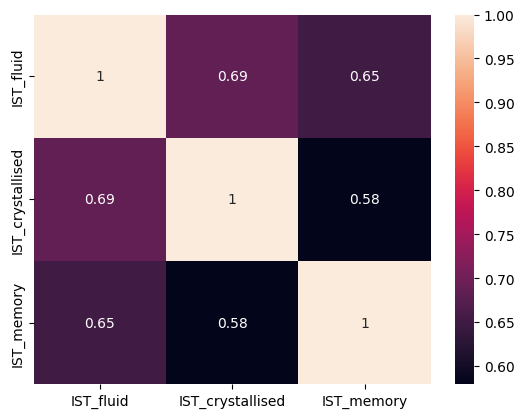

In [10]:
#correlation map of the 3 features to predict. IST_fluid, IST_crystallised, IST_memory
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(df_full[targets].corr(), annot=True)

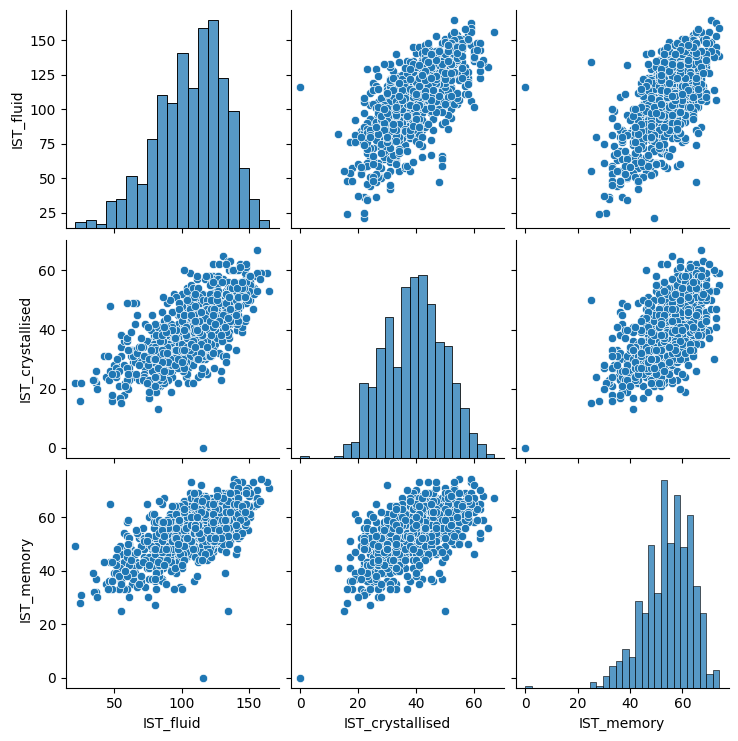

In [11]:
# Pairplot of the 3 features to predict. Correlation and distribution of the targets
sns.pairplot(df_full[["IST_fluid", "IST_crystallised", "IST_memory"]])

### Entrenamiento

In [12]:
cv = RepeatedContinuousStratifiedKFold(3, n_splits=3, n_repeats=10, random_state=42)

In [13]:
search_params = {
    "kind": "bayes",
    "n_iter": 50,
    # "cv": 3
}

# Model 1 (SVM)
creator1 = PipelineCreator(problem_type="regression")
creator1.add("zscore")
creator1.add("svm",
             kernel="linear",
             C=(1e-6, 1, "log-uniform"),
             epsilon=(0.01, 3, "log-uniform")
            )

creator2 = PipelineCreator(problem_type="regression")
creator2.add("zscore")
creator2.add("svm", 
             kernel=["rbf", "sigmoid"],
             C=(1e-6, 1, "log-uniform"),
             gamma=[1e-5, 1e-4, 1e-3, 1e-2, "scale", "auto"],
             epsilon=(0.01, 3, "log-uniform")
            )

# Model 2 (Random Forest)
creator3 = PipelineCreator(problem_type="regression")
creator3.add("zscore")
creator3.add("rf", n_estimators=[25, 50, 100], max_depth=[5, 10, 20])

# Model 3 (Gradient Boosting)
creatorXG = PipelineCreator(problem_type="regression")
creatorXG.add("zscore")
creatorXG.add("gradientboost", n_estimators=[25, 50, 100], max_depth=[3, 5, 10], random_state=42)

# Model 4 (Dummy)
dummy_creator = PipelineCreator(problem_type="regression")
dummy_creator.add("zscore")
dummy_creator.add("dummy")

2024-06-05 18:15:09,352 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-05 18:15:09,354 - julearn - INFO - Step added
2024-06-05 18:15:09,355 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-05 18:15:09,357 - julearn - INFO - Setting hyperparameter kernel = linear
2024-06-05 18:15:09,358 - julearn - INFO - Tuning hyperparameter C = (1e-06, 1, 'log-uniform')
2024-06-05 18:15:09,359 - julearn - INFO - Tuning hyperparameter epsilon = (0.01, 3, 'log-uniform')
2024-06-05 18:15:09,361 - julearn - INFO - Step added
2024-06-05 18:15:09,363 - julearn - INFO - Adding step zscore that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:type:__continuous)>
2024-06-05 18:15:09,364 - julearn - INFO - Step added
2024-06-05 18:15:09,366 - julearn - INFO - Adding step svm that applies to ColumnTypes<types={'continuous'}; pattern=(?:__:typ

In [14]:
scores_dict = {t: {} for t in targets}
model_dict = {t: {} for t in targets}
inspector_dict = {t: {} for t in targets}

models = {'SVM': [creator1, creator2], 'RF': creator3, 'XGBoost': creatorXG, 'Dummy': dummy_creator}

### Visualización

In [15]:
from julearn.viz import plot_scores

In [16]:
for y in targets:
    for m_name, m in models.items():
        scores, model, inspector = run_cross_validation(
            X=X,
            y=y,
            data=df_full,
            model= m,
            return_train_score=True,
            return_inspector=True,
            cv=cv,
            scoring="neg_mean_absolute_error",
            search_params=search_params,
        )
        scores['model'] = m_name
        scores_dict[y][m_name] = scores
        model_dict[y][m_name] = model
        inspector_dict[y][m_name] = inspector

2024-06-05 18:15:10,375 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-05 18:15:10,376 - julearn - INFO - ==== Input Data ====
2024-06-05 18:15:10,378 - julearn - INFO - Using dataframe as input
2024-06-05 18:15:10,379 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-05 18:15:10,436 - julearn - INFO - ====================
2024-06-05 18:15:10,437 - julearn - INFO - 
2024-06-05 18:15:10,441 - julearn - INFO - = Model Parameters =
2024-06-05 18:15:10,443 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-05 18:15:10,444 - julearn - INFO - Hyperparameters:
2024-06-05 18:15:10,445 - julearn - INFO - 	svm__C: (1e-06, 1, 'log-uniform')
2024-06-05 18:15:10,446 - julearn - INFO - 	svm__epsilon: (0.01, 3, 'log-uniform')
2024-06-05 18:15:10,447 - julearn - INFO - Hyperparameter svm__C as is (1e-06, 1, 'log-uniform')
2024-06-05 18:15:10,448 - julearn - INFO - Hyperparameter svm__epsilon as is (0.01, 3, 'log-uniform')
2024-06-05 18:15:10,450 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-05 18:15:10,451 - julearn - INFO - Search Parameters:
2024-06-05 18:15:10,452 - julearn - INFO - 	n_iter: 50
2024-06-05 18:15:10,454 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=Fal

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.00019563232143535414, 0.07633658406139542, 0.01, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardScaler()] before, using random point [SetColumnTypes(X_types={}), SVR(), 0.02361878245622509, 0.11481662898453004, 0.001, 'rbf', StandardScaler()]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [SetColumnTypes(X_types={}), SVR(), 1.0, 0.01, 0.001, 'rbf', StandardS

2024-06-05 19:41:41,629 - julearn - INFO - Fitting final model
2024-06-05 19:44:17,787 - julearn - INFO - Inspector requested: setting return_estimator='all'
2024-06-05 19:44:17,788 - julearn - INFO - ==== Input Data ====
2024-06-05 19:44:17,789 - julearn - INFO - Using dataframe as input
2024-06-05 19:44:17,790 - julearn - INFO - 	Features: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17'

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/julearn/prepare.py:505: RuntimeWarning: The following columns are not defined in X_types: ['LH_Vis_1', 'LH_Vis_2', 'LH_Vis_3', 'LH_Vis_4', 'LH_Vis_5', 'LH_Vis_6', 'LH_Vis_7', 'LH_Vis_8', 'LH_Vis_9', 'LH_Vis_10', 'LH_Vis_11', 'LH_Vis_12', 'LH_Vis_13', 'LH_Vis_14', 'LH_Vis_15', 'LH_Vis_16', 'LH_Vis_17', 'LH_Vis_18', 'LH_Vis_19', 'LH_Vis_20', 'LH_Vis_21', 'LH_Vis_22', 'LH_Vis_23', 'LH_Vis_24', 'LH_Vis_25', 'LH_Vis_26', 'LH_Vis_27', 'LH_Vis_28', 'LH_Vis_29', 'LH_Vis_30', 'LH_Vis_31', 'LH_SomMot_1', 'LH_SomMot_2', 'LH_SomMot_3', 'LH_SomMot_4', 'LH_SomMot_5', 'LH_SomMot_6', 'LH_SomMot_7', 'LH_SomMot_8', 'LH_SomMot_9', 'LH_SomMot_10', 'LH_SomMot_11', 'LH_SomMot_12', 'LH_SomMot_13', 'LH_SomMot_14', 'LH_SomMot_15', 'LH_SomMot_16', 'LH_SomMot_17', 'LH_SomMot_18', 'LH_SomMot_19', 'LH_SomMot_20', 'LH_SomMot_21', 'LH_SomMot_22', 'LH_SomMot_23', 'LH_SomMot_24', 'LH_SomMot_25', 'LH_SomMot_26', 'LH_SomMot_27', 'LH_SomMot_28', 'LH_SomMot_

2024-06-05 19:44:17,827 - julearn - INFO - ====================
2024-06-05 19:44:17,827 - julearn - INFO - 
2024-06-05 19:44:17,829 - julearn - INFO - = Model Parameters =
2024-06-05 19:44:17,830 - julearn - INFO - Tuning hyperparameters using bayes
2024-06-05 19:44:17,830 - julearn - INFO - Hyperparameters:
2024-06-05 19:44:17,831 - julearn - INFO - 	rf__n_estimators: [25, 50, 100]
2024-06-05 19:44:17,832 - julearn - INFO - 	rf__max_depth: [5, 10, 20]
2024-06-05 19:44:17,833 - julearn - INFO - Hyperparameter rf__n_estimators as is [25, 50, 100]
2024-06-05 19:44:17,834 - julearn - INFO - Hyperparameter rf__max_depth as is [5, 10, 20]
2024-06-05 19:44:17,835 - julearn - INFO - Using inner CV scheme KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-05 19:44:17,836 - julearn - INFO - Search Parameters:
2024-06-05 19:44:17,837 - julearn - INFO - 	n_iter: 50
2024-06-05 19:44:17,838 - julearn - INFO - 	cv: KFold(n_splits=5, random_state=None, shuffle=False)
2024-06-05 19:44:17,842 

/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 100] before, using random point [5, 25]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 100] before, using random point [20, 100]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 100] before, using random point [5, 50]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been evaluated at point [5, 100] before, using random point [5, 100]
  warnings.warn(
/home/lucas/miniconda3/envs/neurodc/lib/python3.11/site-packages/skopt/optimizer/optimizer.py:517: UserWarning: The objective has been ev

In [ ]:
for y in targets:
    for est in scores_dict[y]['SVM'].estimator:
        print("=================== " + y + " ======================")
        display(est.best_params_)

{'set_column_types': SetColumnTypes(X_types={}),
 'svm': SVR(),
 'svm__C': 1,
 'svm__epsilon': 0.01,
 'svm__gamma': 'auto',
 'svm__kernel': 'sigmoid',
 'zscore': StandardScaler()}

{'set_column_types': SetColumnTypes(X_types={}),
 'svm': SVR(),
 'svm__C': 1,
 'svm__epsilon': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'sigmoid',
 'zscore': StandardScaler()}

{'set_column_types': SetColumnTypes(X_types={}),
 'svm': SVR(),
 'svm__C': 1,
 'svm__epsilon': 0.01,
 'svm__gamma': 'scale',
 'svm__kernel': 'sigmoid',
 'zscore': StandardScaler()}

{'set_column_types': SetColumnTypes(X_types={}),
 'svm': SVR(),
 'svm__C': 1,
 'svm__epsilon': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'sigmoid',
 'zscore': StandardScaler()}

{'set_column_types': SetColumnTypes(X_types={}),
 'svm': SVR(),
 'svm__C': 1,
 'svm__epsilon': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'sigmoid',
 'zscore': StandardScaler()}

In [ ]:
for y in targets:
    holdout_pred1, holdout_pred2, holdout_pred3, holdout_pred4 = tuple(model_dict[y][m].predict(df_holdout[X]) for m in models)
    s1, s2, s3, s4 = tuple(scores_dict[y].values())
    panel = plot_scores(s1, s2, s3, s4)
    
    panel.show()

In [ ]:
# correlation scatter plot for the best model, predict vs ground truth
fig, ax = plt.subplots((2, 2), figsize=(10, 10))

for i, m_name in enumerate(models):
    y_true = df_holdout['IST_intelligence_total']
    y_pred_fluid = model_dict['IST_fluid'][m_name].predict(df_holdout[X])
    y_pred_memory = model_dict['IST_memory'][m_name].predict(df_holdout[X])
    y_pred_crystallised = model_dict['IST_crystallised'][m_name].predict(df_holdout[X])

    y_pred = y_pred_fluid + y_pred_memory + y_pred_crystallised

    ax[i//2][i%2] = sns.scatterplot(x=y_true, y=y_pred, alpha=0.5)
    ax[i//2][i%2].set_title(f"IST_intelligence_total vs {m_name} prediction")
    ax[i//2][i%2].set_xlabel("IST_intelligence_total")
    ax[i//2][i%2].set_ylabel("Prediction")
    ax[i//2][i%2].plot([0, 1], [0, 1], transform=ax[i//2][i%2].transAxes, color='red', linestyle='--')
    

In [ ]:
# from bokeh.plotting import figure, output_file, show

# # output to static HTML file
# output_file("line.html")

# p = figure(width=400, height=400)

# # add a circle renderer with a size, color, and alpha
# p.circle([1, 2, 3, 4, 5], [6, 7, 2, 4, 5], size=20, color="navy", alpha=0.5)

# # show the results
# show(p)